# Notebook for testing diffusion models regarding parameters such as grain/domain size and cooling rate for different thermochronology systems

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.constants import Julian_year
from scipy.optimize import minimize
%config InlineBackend.figure_format='retina'

## compilation of diffusion paramter from experimental results  

In [2]:
diffusion_compilation = pd.read_csv('../data/thermochron_compilation/element_diffusion_compilation.csv')
diffusion_compilation = diffusion_compilation[diffusion_compilation['color'].notna()]
diffusion_compilation = diffusion_compilation[diffusion_compilation['Host'] == 'Zircon']
diffusion_compilation = diffusion_compilation.reset_index()
diffusion_compilation.head()

index    Host Composition Element    E  E_sigma            D0  \
0     15  Zircon      zircon      Pb  545     25.0  7.760000e-02   
1     16  Zircon      zircon       U  726     83.0  1.630000e+00   
2     17  Zircon      zircon      Ti  754     56.0  3.330000e+02   
3     18  Zircon      zircon      Yb  691     47.0  2.510000e+07   
4     19  Zircon      zircon      Dy  743     35.0  2.290000e+05   

   Pressure (Mpa)  Temp low  Temp high                          Ref    color  
0             0.1    1000.0     1500.0  Cherniak and Watson (2001)   #00FFFF  
1             0.1    1450.0     1600.0     Cherniak et al. (1997b)   #A9F5F2  
2             0.1    1350.0     1550.0  Cherniak and Watson (2007)   #0080FF  
3             0.1    1150.0     1650.0                          NaN  #0101DF  
4             0.1    1150.0     1400.0                          NaN  #8000FF

In [3]:
plag_zirc_data = diffusion_compilation[diffusion_compilation['Composition'].str.contains(
    '|'.join(['An', 'zircon']))]
plag_zirc_data = plag_zirc_data.reset_index(drop=True)
plag_zirc_data

index    Host Composition Element    E  E_sigma            D0  \
0     15  Zircon      zircon      Pb  545     25.0  7.760000e-02   
1     16  Zircon      zircon       U  726     83.0  1.630000e+00   
2     17  Zircon      zircon      Ti  754     56.0  3.330000e+02   
3     18  Zircon      zircon      Yb  691     47.0  2.510000e+07   
4     19  Zircon      zircon      Dy  743     35.0  2.290000e+05   
5     20  Zircon      zircon      Sm  841     57.0  2.880000e+08   
6     21  Zircon      zircon      Hf  812     54.0  1.610000e+03   
7     22  Zircon      zircon      Th  792     34.0  8.630000e+01   
8     23  Zircon      zircon      Li  275     11.0  7.170000e-07   

   Pressure (Mpa)  Temp low  Temp high                          Ref    color  
0             0.1    1000.0     1500.0  Cherniak and Watson (2001)   #00FFFF  
1             0.1    1450.0     1600.0     Cherniak et al. (1997b)   #A9F5F2  
2             0.1    1350.0     1550.0  Cherniak and Watson (2007)   #0080FF  
3             0.1    1150.0     1650.0                          NaN  #0101DF  
4             0.1    1150.0     1400.0                          NaN  #8000FF  
5             0.1    1150.0     1400.0                          NaN  #A901DB  
6             0.1    1400.0     1600.0                          NaN  #FA58D0  
7             0.1    1450.0     1650.0                          NaN  #000000  
8             0.1     700.0     1150.0                          NaN  #A4A4A4

In [4]:
def plot_logD_vs_T(df):
    R = 8.314462618
    fig, ax = plt.subplots(figsize=(10,12))
    for i in range(df.shape[0]):
        Temp_steps = np.linspace(df['Temp low'][i]+273.15, df['Temp high'][i]+273.15, 50)
        Temp_steps_rev = 10000/Temp_steps
        logDs = np.log10(df['D0'][i] * np.exp(-df['E'][i]*1000/R/Temp_steps))
        
        ax.plot(Temp_steps_rev, logDs, label = df['Composition'][i]+ ' ' +df['Element'][i], 
                color = df['color'][i])
    return fig, ax

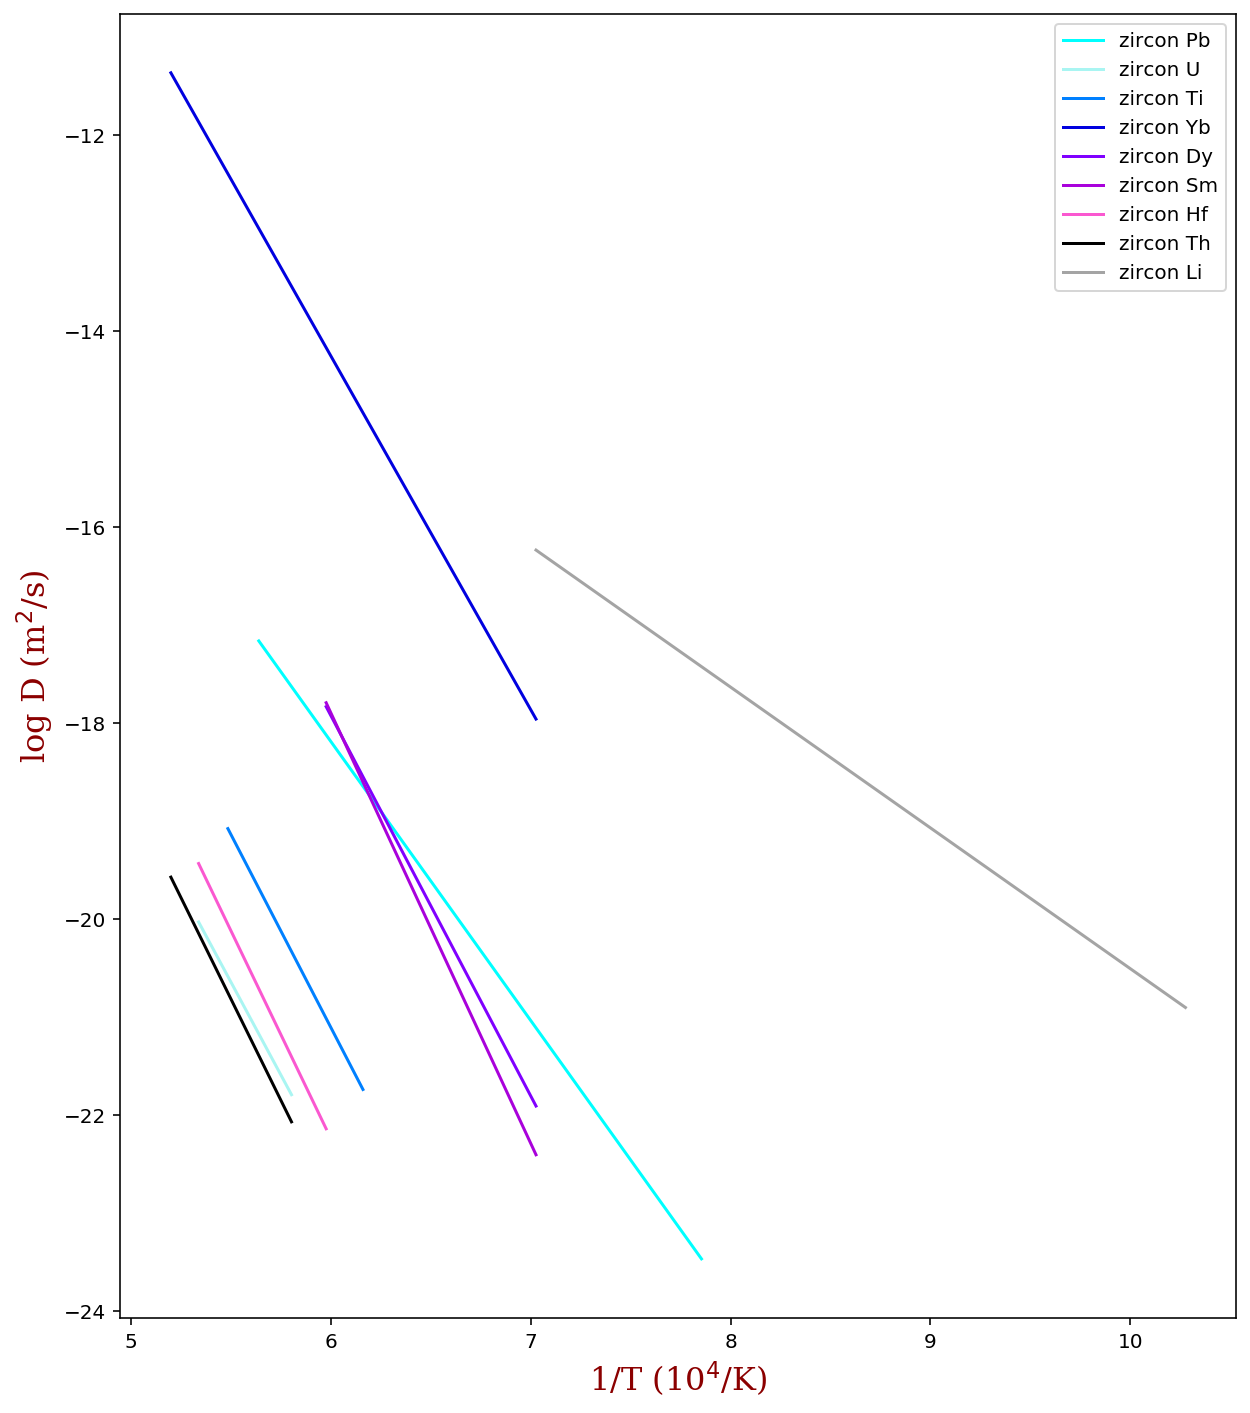

In [5]:
plot_logD_vs_T(diffusion_compilation)
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

plt.xlabel('1/T (10$^4$/K)',fontdict=font)
plt.ylabel('log D (m$^2$/s)',fontdict=font)
plt.legend()

## calculation of closure temperatures based on cooling rate

In [6]:
def closure_temps(Tc, E, D0, R, A, a, cooling_rate):
    def solution(Tc):
        return abs(E/R/Tc-np.log(A*R*Tc**2*D0/a**2/E/cooling_rate))
    Tc = Tc+273.15
    return minimize(solution, Tc)['x']-273.15

In [7]:
R = 8.314462618
A = 55

In [8]:
columns=['mineral', 'a', 'b', 'c']
log_closure_temp_fit_df = pd.DataFrame(columns=columns)

### Bioite Ar closure temperature calculation and fit

a:  0.3 b:  12.0 c:  272.1


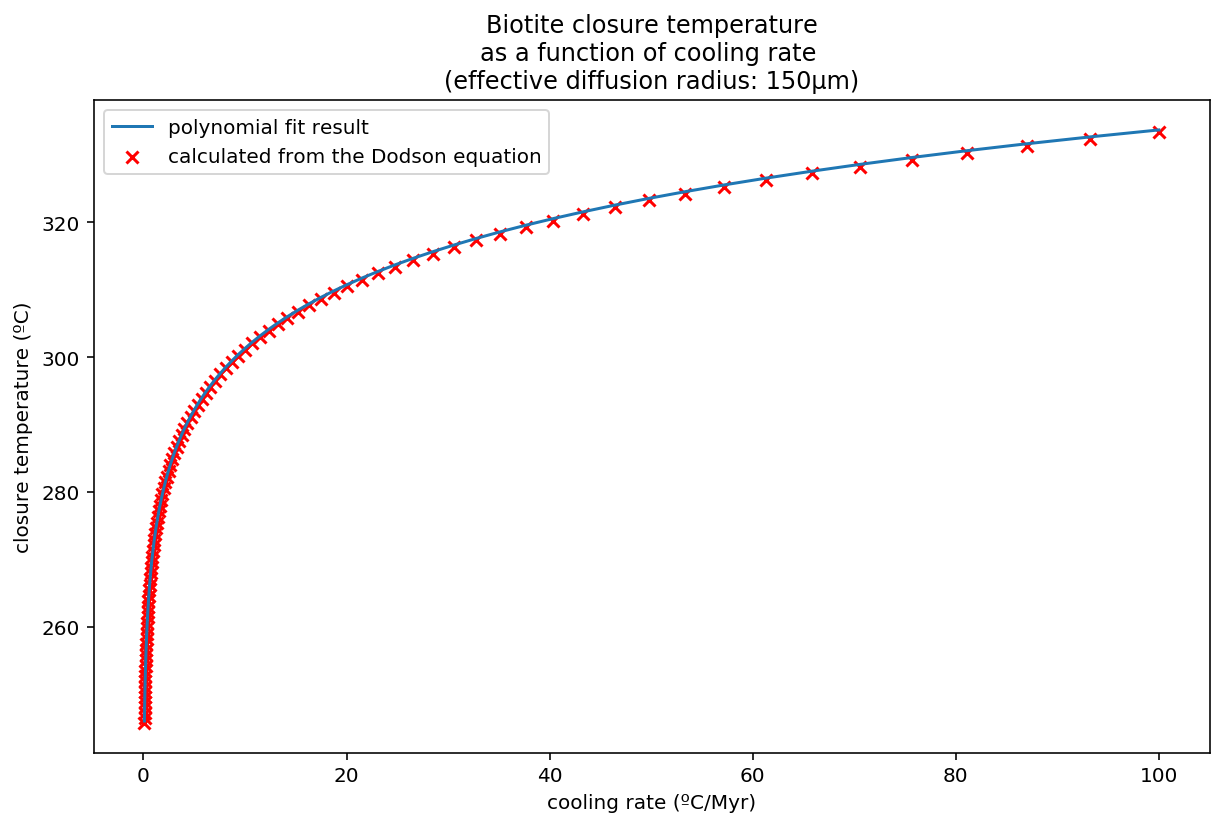

In [9]:
biotite_E = 197*1000

biotite_D0 = 0.0000077
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

biotite_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(300, biotite_E, biotite_D0, R, A, biotite_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Biotite', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c

plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Biotite closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

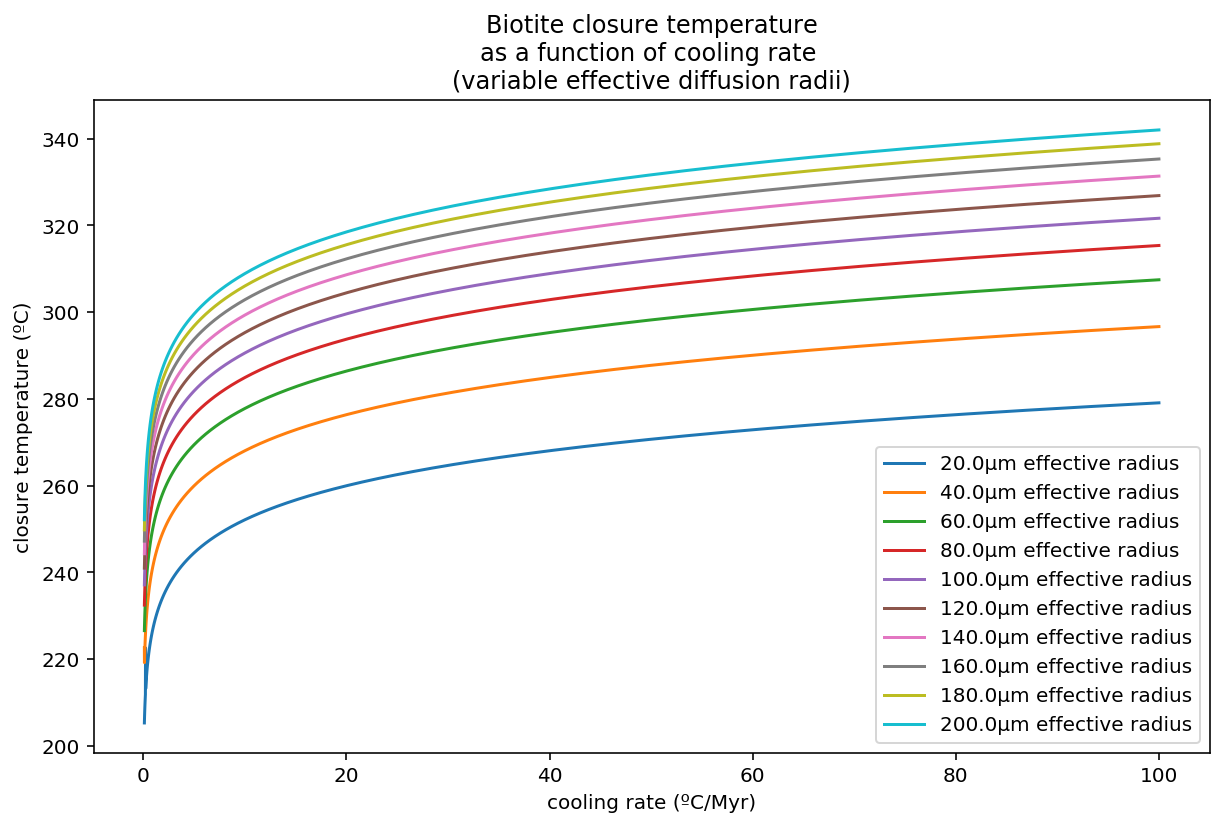

In [10]:
biotite_a = np.linspace(20, 200, 10)/1e6

plt.figure(figsize=(10, 6))

for a in biotite_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(300, biotite_E, biotite_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Biotite closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Hornblende Ar closure temperature calculation and fit

a:  0.4 b:  17.0 c:  482.8


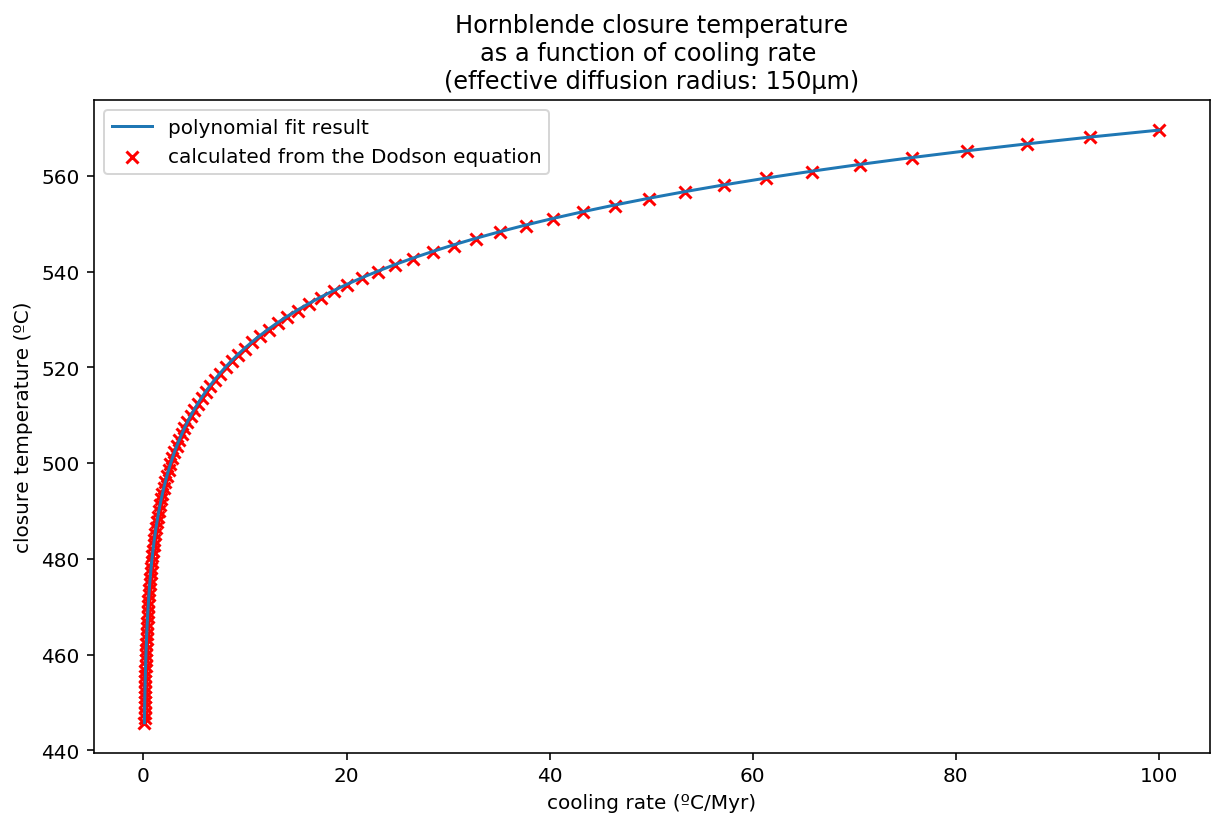

In [11]:
hornblende_E = 268*1000

hornblende_D0 = 0.0000024
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

hornblende_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(300, hornblende_E, hornblende_D0, R, A, hornblende_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Hornblende', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c

plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Hornblende closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

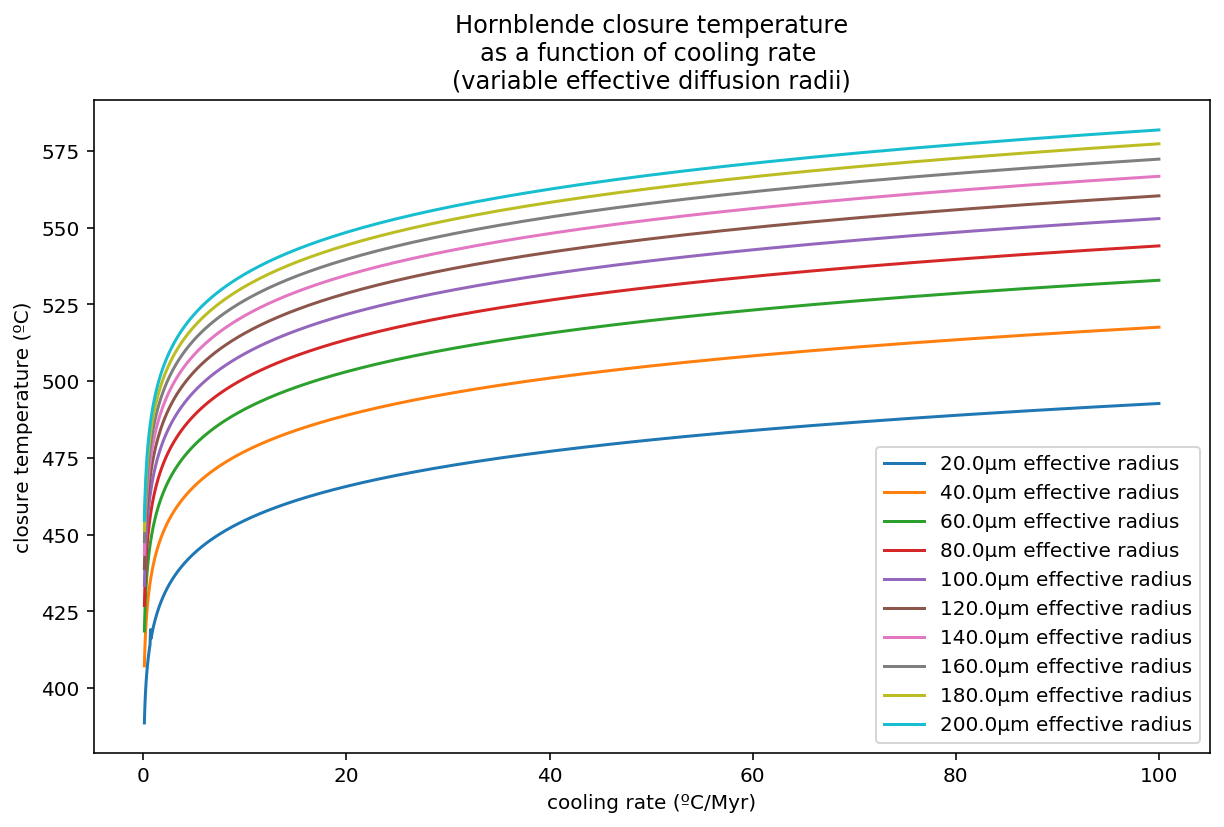

In [20]:
hornblende_a = np.linspace(20, 200, 10)/1e6

plt.figure(figsize=(10, 6))

for a in hornblende_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(480, hornblende_E, hornblende_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Hornblende closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Rutile Pb closure temperature calculation and fit

a:  0.7 b:  24.1 c:  603.9


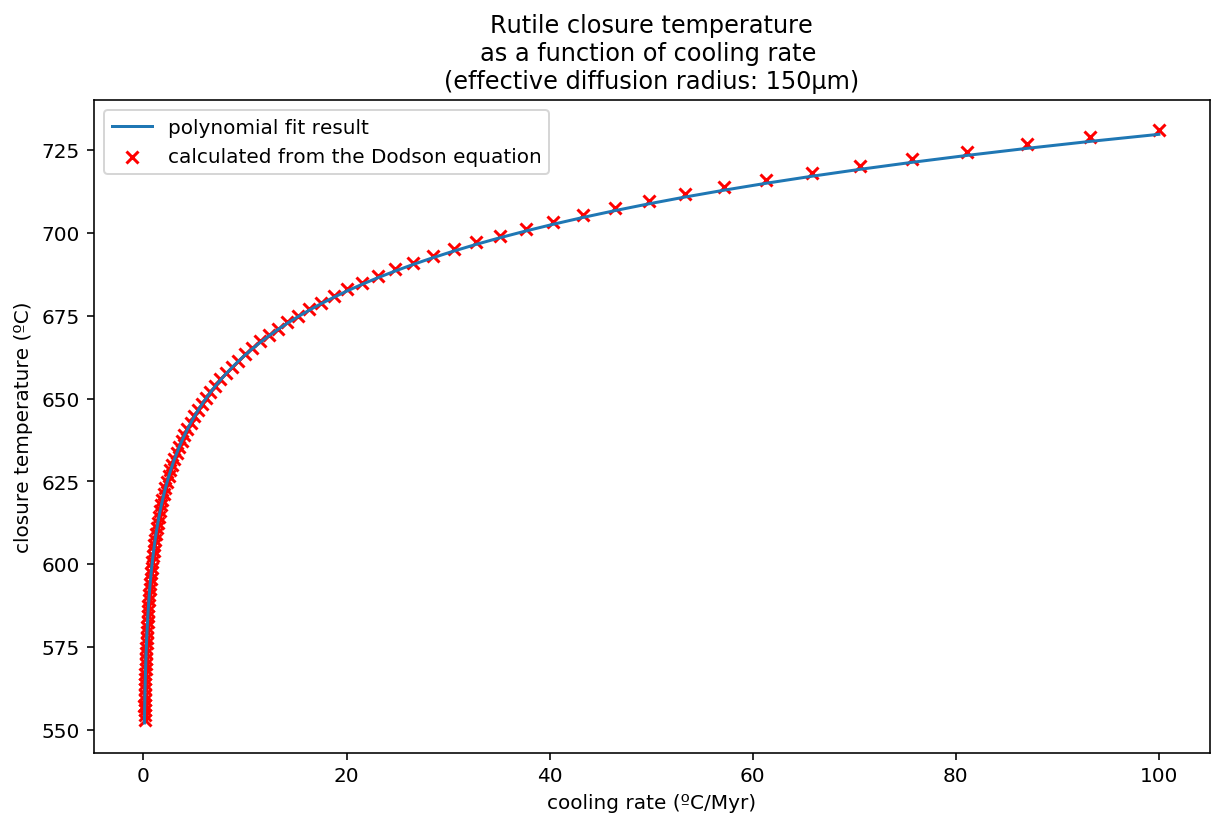

In [13]:
rutile_E = 250*1000

rutile_D0 = 3.9E-10
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

rutile_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(600, rutile_E, rutile_D0, R, A, rutile_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Rutile', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c

plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Rutile closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

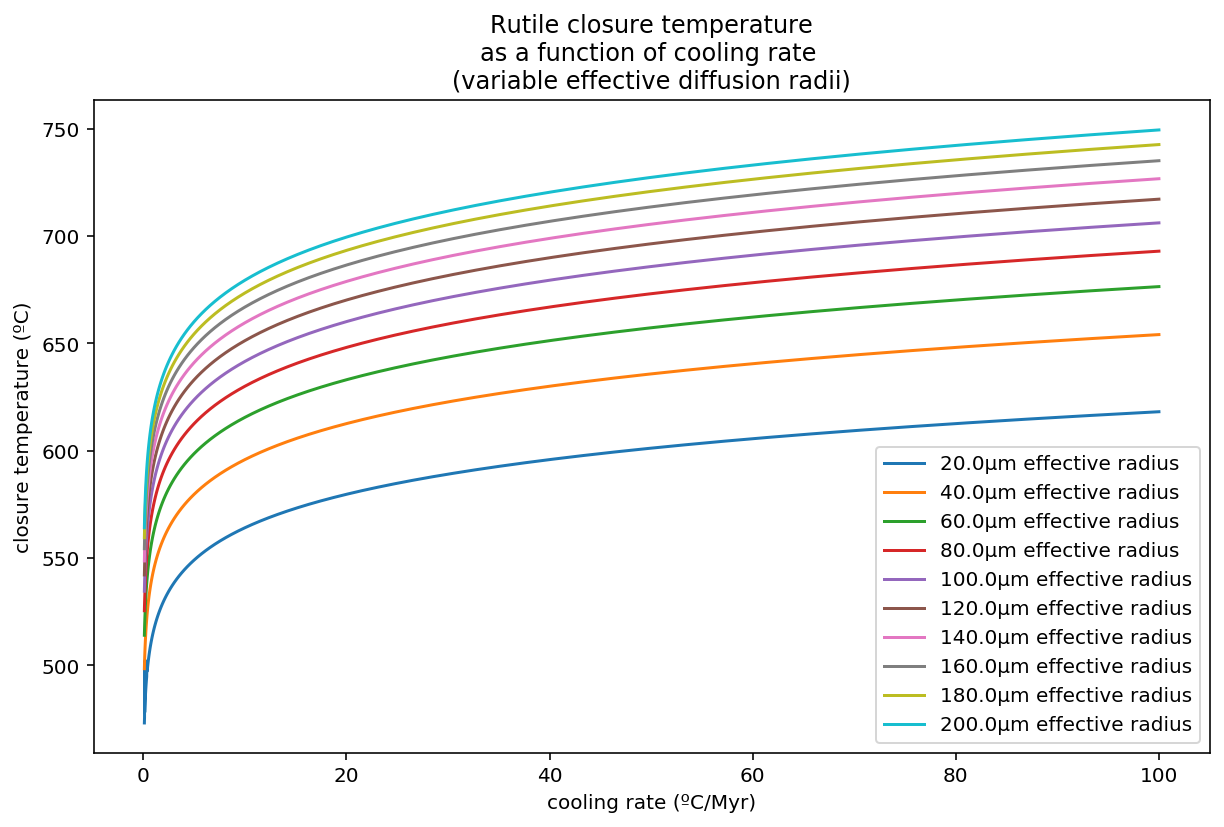

In [21]:
rutile_a = np.linspace(20, 200, 10)/1e6

plt.figure(figsize=(10, 6))

for a in rutile_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(550, rutile_E, rutile_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Rutile closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Titanite Pb closure temperature calculation and fit

a:  0.4 b:  17.6 c:  577.7


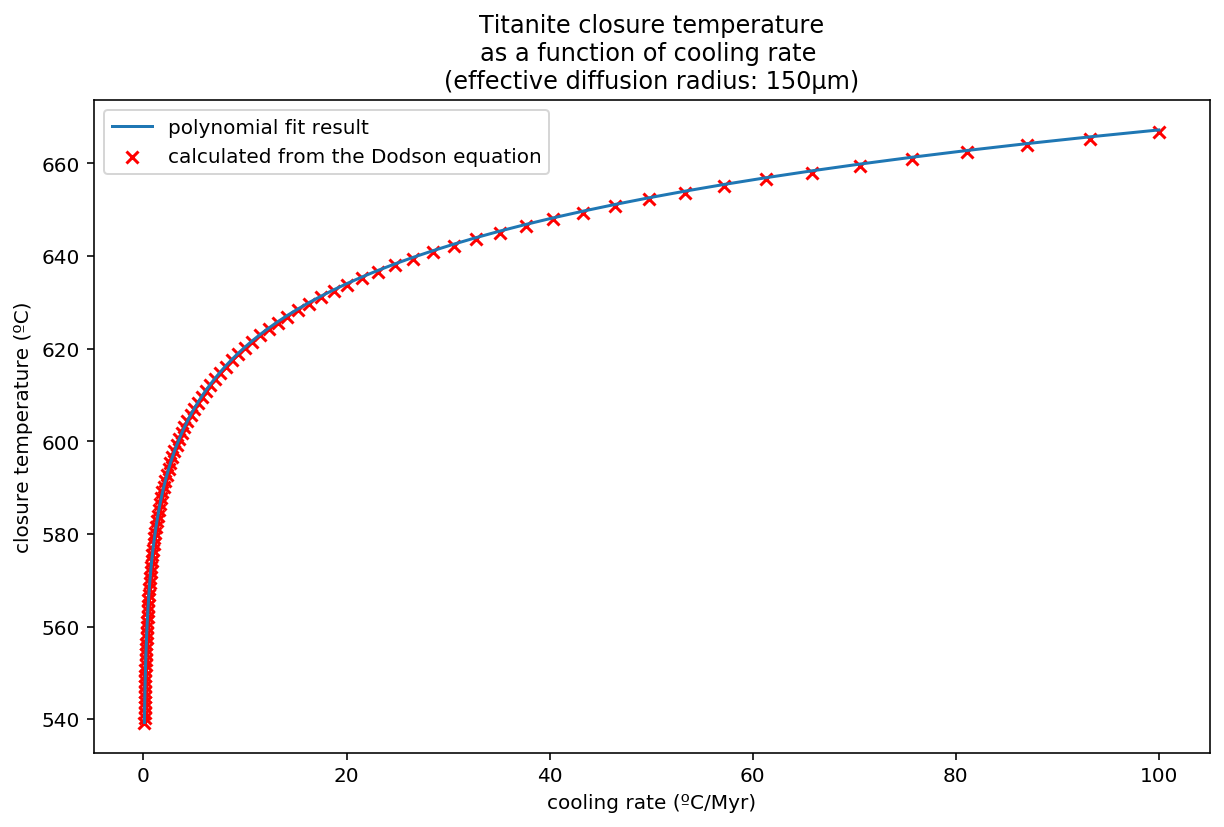

In [15]:
titanite_E = 329*1000

titanite_D0 = 0.000111
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

titanite_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(600, titanite_E, titanite_D0, R, A, titanite_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Titanite', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c

plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Titanite closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

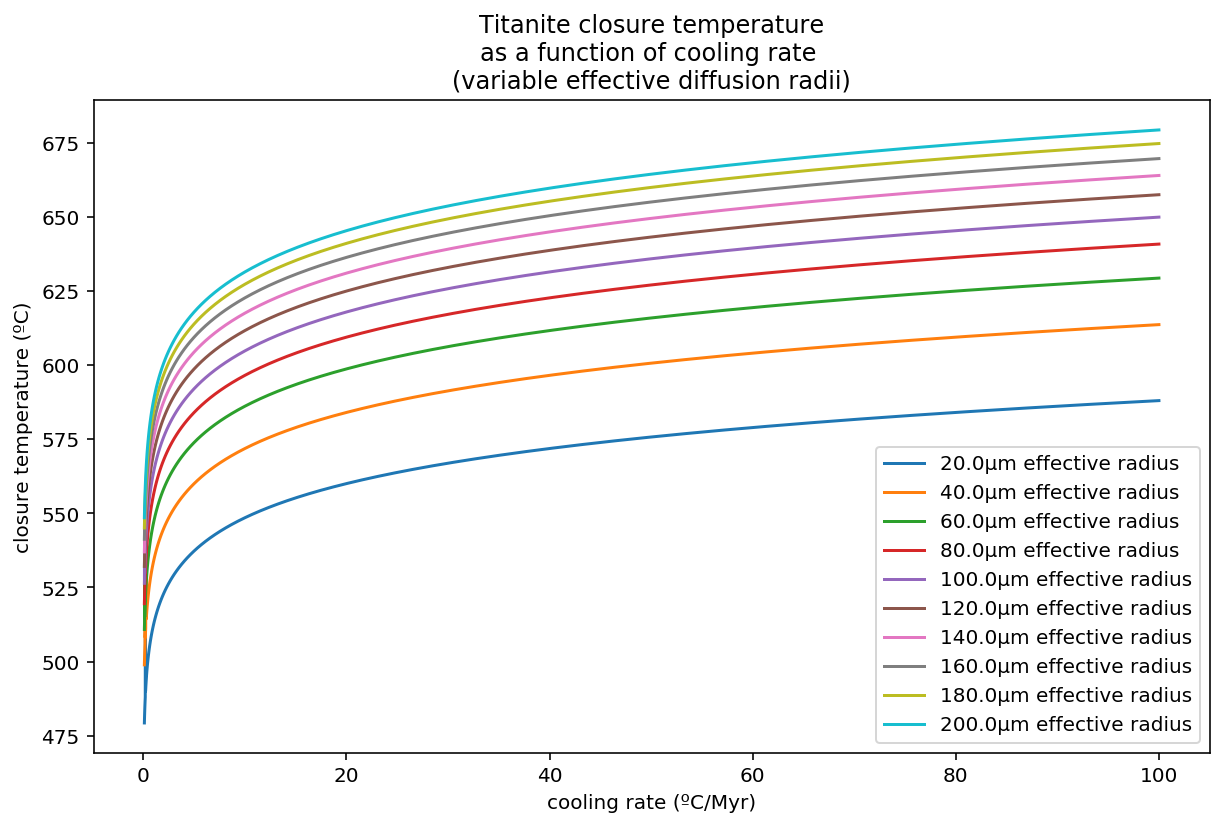

In [16]:
titanite_a = np.linspace(20, 200, 10)/1e6

plt.figure(figsize=(10, 6))

for a in titanite_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(600, titanite_E, titanite_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Titanite closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Monazite Pb closure temperature calculation and fit

a:  0.4 b:  22.1 c:  1003.6


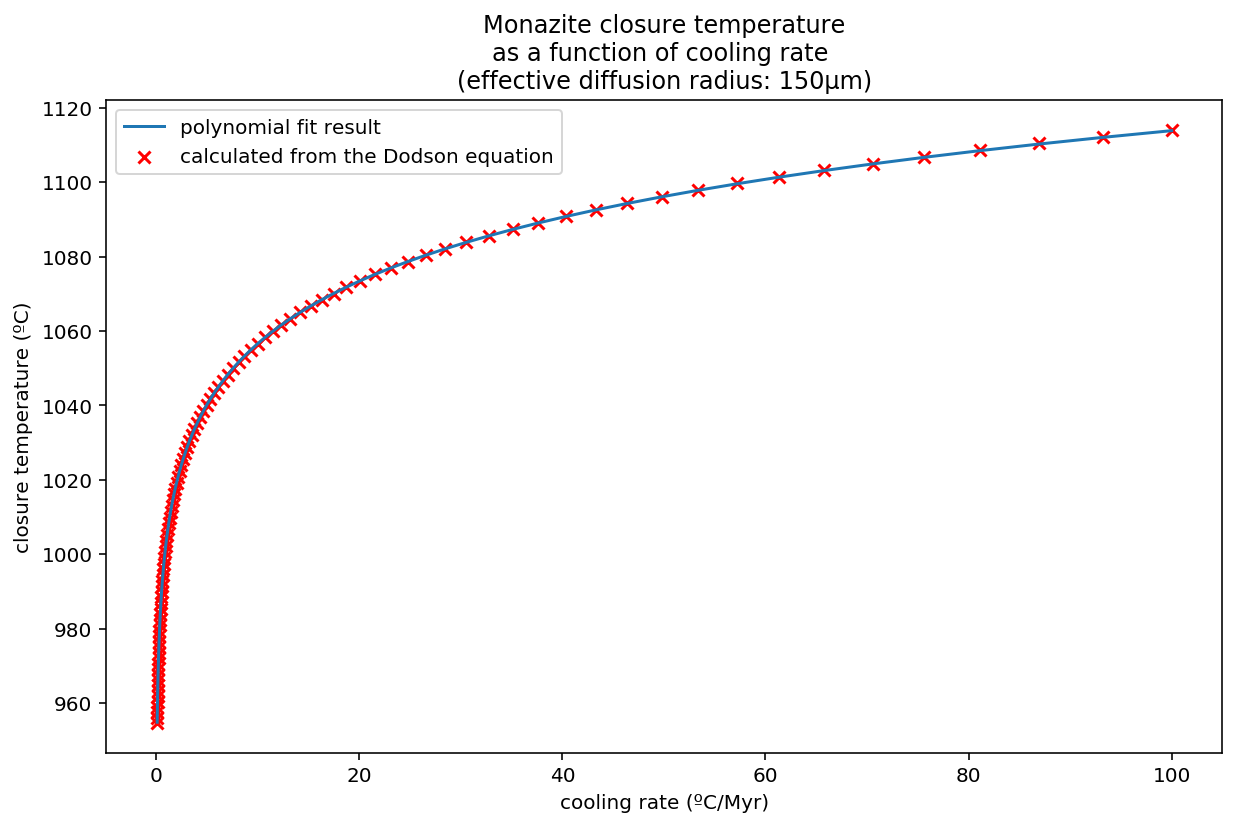

In [17]:
monazite_E = 592*1000

monazite_D0 = 9.38E-01
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

monazite_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(1000, monazite_E, monazite_D0, R, A, monazite_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Monazite', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c

plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Monazite closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

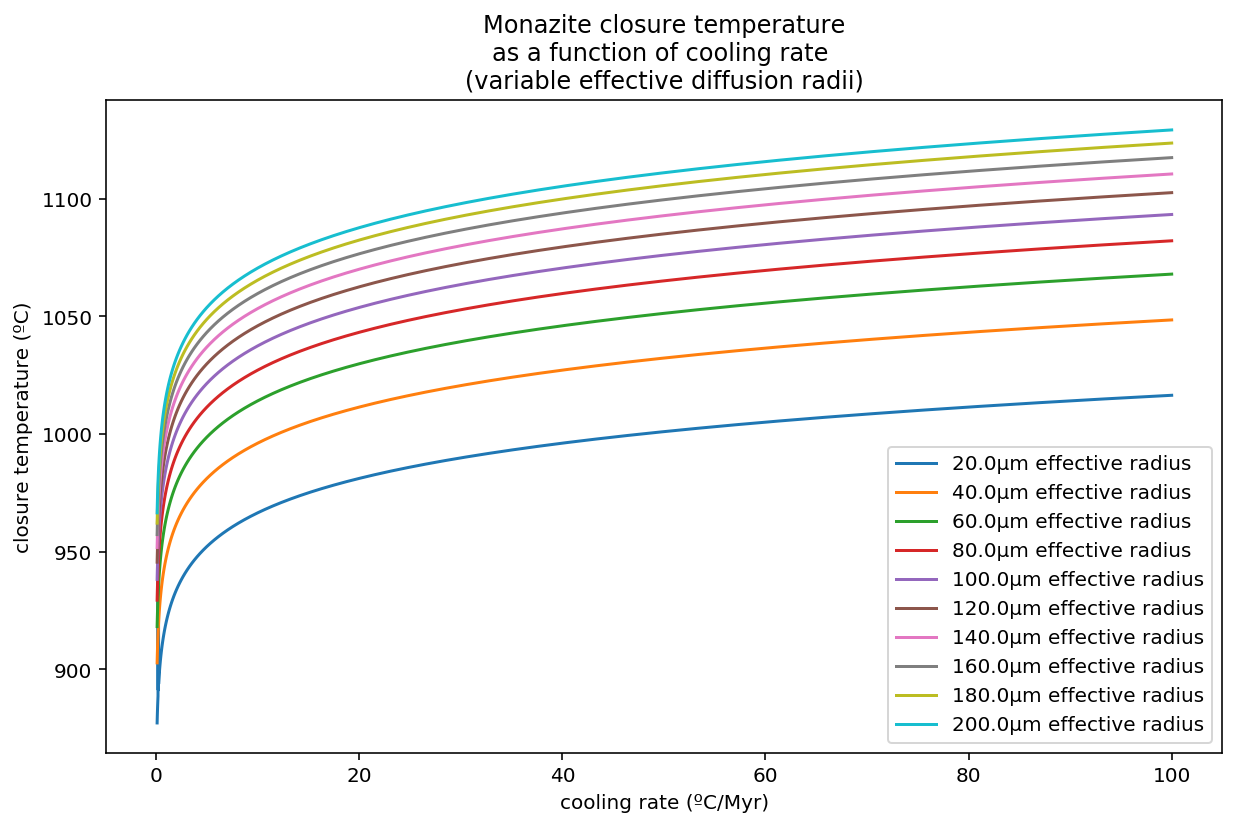

In [18]:
monazite_a = np.linspace(20, 200, 10)/1e6

plt.figure(figsize=(10, 6))

for a in titanite_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(1000, monazite_E, monazite_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Monazite closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

In [22]:
log_closure_temp_fit_df

mineral    a     b       c
0     Biotite  0.3  12.0   272.1
1  Hornblende  0.4  17.0   482.8
2      Rutile  0.7  24.1   603.9
3    Titanite  0.4  17.6   577.7
4    Monazite  0.4  22.1  1003.6

In [23]:
log_closure_temp_fit_df.to_csv('code_output/closure_temp_fits_150.csv')

## Evaluting the Pb of diffusive loss in zircon

Shown below are conditions for diffusional Pb loss in crystalline zircon for zircons of effective radii of 100 µm. Curves represent time–temperature conditions under which zircon will lose the indicated fraction of total Pb.


- Cherniak, D. J., & Watson, E. B. (2001). Pb diffusion in zircon. Chemical Geology, 172(1-2), 5-24.

In [6]:
R = 8.314462618
T = 1000+273

def get_temp_from_yr(diff_length, yrs):
    return -545000/np.log((diff_length/1000000)**2/0.0776/Julian_year/yrs)/R - 273.15


In [ ]:
# to get % loss we need:
def temp_yr_given_perc(percent_loss = 0.9, eff_radii=100, yrs = np.logspace(0, 9, 50)):
    eff_radii = eff_radii
    perc_loss = percent_loss
    zircon_vol = 4/3*np.pi*eff_radii**3
    left_vol = zircon_vol*(1-perc_loss)*3/4/np.pi
    left_radii = np.cbrt(left_vol)

    diff_length = eff_radii-left_radii

    yrs = yrs

    temps = get_temp_from_yr(diff_length, yrs)
    return temps

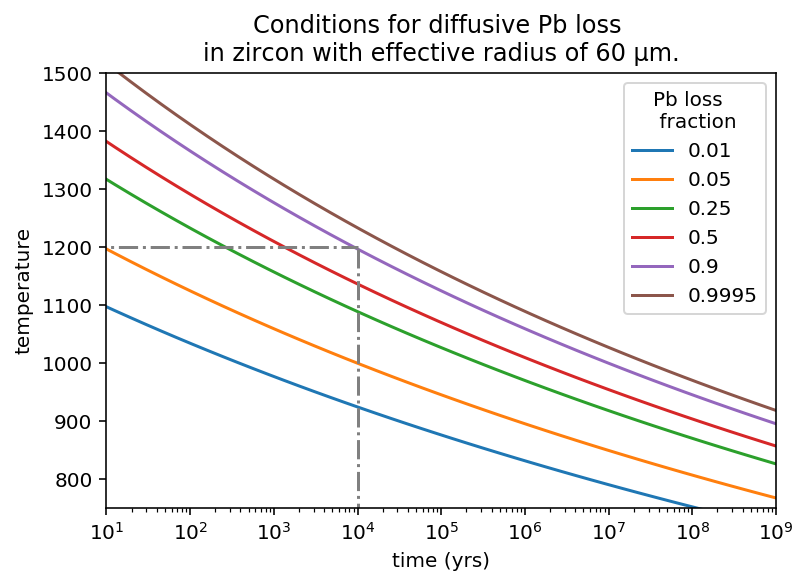

In [9]:
perc = [0.01, 0.05, 0.25, 0.5, 0.9, 0.9995]
yrs = np.logspace(0, 9, 50)
temps = []
for i in perc:
    temps.append(temp_yr_given_perc(percent_loss = i, eff_radii=60, yrs = np.logspace(0, 9, 50)))
for i in range(len(temps)):
    plt.plot(yrs, temps[i], label=str(perc[i]))
    
plt.plot([1,1e4], [1200, 1200], '-.',color = 'grey', )
plt.plot([1e4,1e4], [0, 1200], '-.',color = 'grey', )
plt.xlim(10, 1e9)
plt.ylim(750, 1500)
plt.xticks([1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])
plt.xscale('log')
plt.legend(title="Pb loss \n fraction")
plt.title('Conditions for diffusive Pb loss \nin zircon with effective radius of 60 µm.')
plt.xlabel('time (yrs)')
plt.ylabel('temperature')
# plt.savefig('code_output/geochron/Pb_loss_condition_60.pdf')
plt.show()

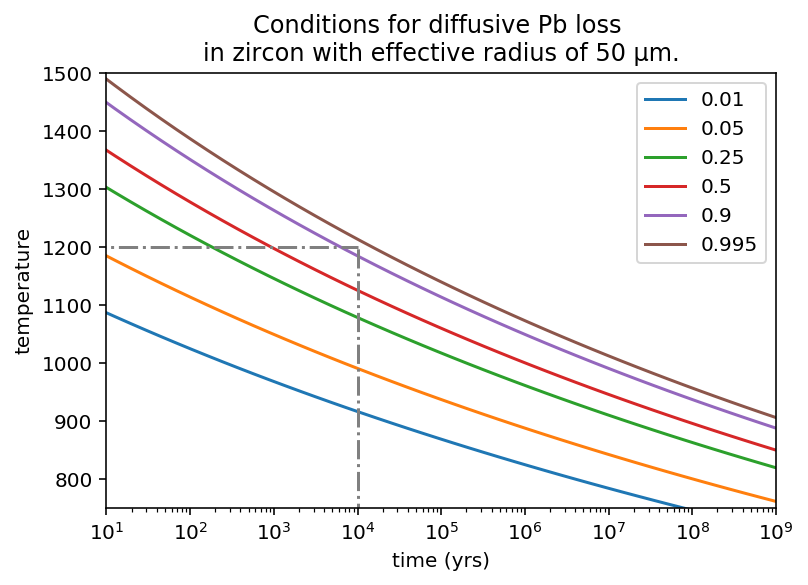

In [10]:
perc = [0.01, 0.05, 0.25, 0.5, 0.9, 0.995]
yrs = np.logspace(0, 9, 50)
temps = []
for i in perc:
    temps.append(temp_yr_given_perc(percent_loss = i, eff_radii=50, yrs = np.logspace(0, 9, 50)))
for i in range(len(temps)):
    plt.plot(yrs, temps[i], label=str(perc[i]))
    
plt.plot([1,1e4], [1200, 1200], '-.',color = 'grey', )
plt.plot([1e4,1e4], [0, 1200], '-.',color = 'grey', )
plt.xlim(10, 1e9)
plt.ylim(750, 1500)
plt.xticks([1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])
plt.xscale('log')
plt.legend()
plt.title('Conditions for diffusive Pb loss \nin zircon with effective radius of 50 µm.')
plt.xlabel('time (yrs)')
plt.ylabel('temperature')
plt.show()

### Evaluating the possible Dy zoning thickness being preserved given >90% Pb loss condition

In [11]:
def get_temp_from_Dy_zoning(zone_thickness, yrs, k=3.3e-2):
    zone_thickness = zone_thickness/1000000/2
    return -743000/np.log(k*zone_thickness**2/Julian_year/yrs/2.29e5)/R - 273.15

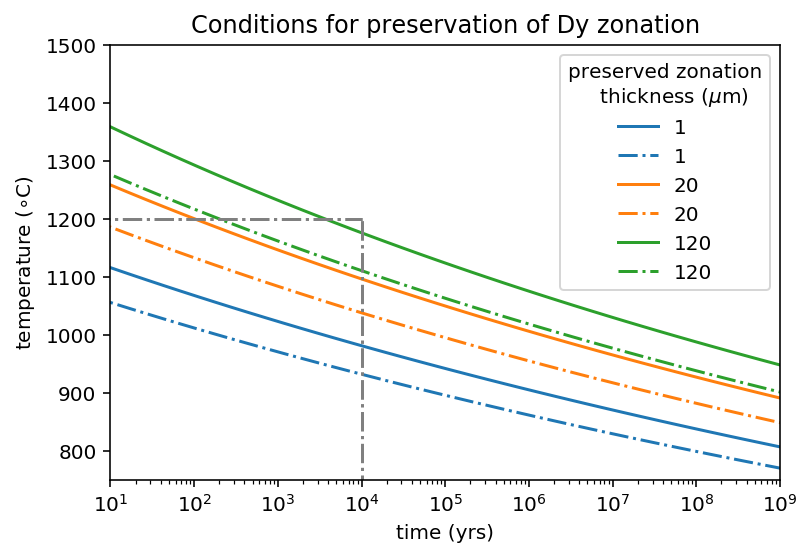

In [12]:
zone_thicknesses = [1, 20, 120]
yrs = np.logspace(0, 10, 50)
disappear_temps = []
fuzzing_temps = []

for i in zone_thicknesses:
    disappear_temps.append(get_temp_from_Dy_zoning(i, yrs, k=3.3e-2))
    fuzzing_temps.append(get_temp_from_Dy_zoning(i, yrs, k=1.8e-3))
for i in range(len(disappear_temps)):
    plt.plot(yrs, disappear_temps[i], label=str(zone_thicknesses[i]), color = 'C'+str(i))
    plt.plot(yrs, fuzzing_temps[i], '-.', label=str(zone_thicknesses[i]), color = 'C'+str(i))
   
    
plt.plot([1,1e4], [1200, 1200], '-.',color = 'grey', )
plt.plot([1e4,1e4], [0, 1200], '-.',color = 'grey', )

plt.plot([1,1e4], [1200, 1200], '-.',color = 'grey', )
plt.plot([1e4,1e4], [0, 1200], '-.',color = 'grey', )
plt.xlim(10, 1e9)
plt.ylim(750, 1500)
plt.xticks([1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])
plt.xscale('log')
plt.legend(title='preserved zonation\n     thickness ($\mu$m)')
# leg.get_title().set_ha("right")
plt.title('Conditions for preservation of Dy zonation')
plt.xlabel('time (yrs)')
plt.ylabel('temperature ($\circ$C)')
# plt.savefig('code_output/geochron/Dy_zoning.pdf')
plt.show()